In [35]:
import pandas as pd
import numpy as np

In [36]:
dataset = pd.read_csv("/content/Eluvio_DS_Challenge.csv")
dataset.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [37]:
len(dataset)

509236

In [38]:
dataset.info() # it looks like nulls donot exist in the dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   category      509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


In [39]:
dataset["author"].value_counts() 

#It looks like the dataset has the (titles) posted by a different authors.

davidreiss666     8897
anutensil         5730
DoremusJessup     5037
maxwellhill       4023
igeldard          4013
                  ... 
ta9876543202         1
BigMeatSpecial       1
MaeveShearlaw        1
freedomt             1
guluarte             1
Name: author, Length: 85838, dtype: int64

In [40]:
print(dataset["category"].value_counts()) 
#there is only one category and that is worldnews, so this variable won't help us in analytics

print("\n",dataset["over_18"].value_counts())
#if we build a model with outcome as over_18, there will be a bias and predictions will be False as the count of False data is more.

worldnews    509236
Name: category, dtype: int64

 False    508916
True        320
Name: over_18, dtype: int64


In [41]:
#let's add a new column which represents the number of characters used within each title

dataset["text_length"] = dataset["title"].apply(len)
dataset.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,text_length
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,33
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,32
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,31
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,44
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,47


# Exploratory Data Analysis

In [42]:
import matplotlib.pyplot as plt

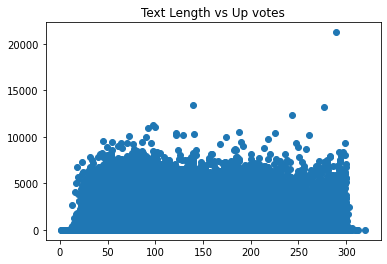

In [43]:
plt.scatter(dataset["text_length"], dataset["up_votes"])
plt.title("Text Length vs Up votes")
plt.show()

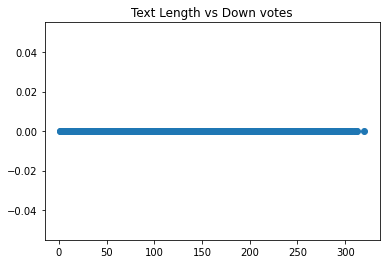

In [44]:
plt.scatter(dataset["text_length"], dataset["down_votes"])
plt.title("Text Length vs Down votes")
plt.show()

#Based on the observattions, there are no downvotes for the titles. 
#So it doesn't make anysense in using this as predictor asit will not effect the outcome variable

**So the only variable that is dependent on title is up_votes.** 

# NLP task

In [45]:
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor 

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.externals import joblib

In [46]:
X = dataset["title"] #predictor variable
y = dataset["up_votes"] #outcome variable

In [47]:
print(X.head())

0                  Scores killed in Pakistan clashes
1                   Japan resumes refuelling mission
2                    US presses Egypt on Gaza border
3       Jump-start economy: Give health care to all 
4    Council of Europe bashes EU&UN terror blacklist
Name: title, dtype: object


**The CountVectorizer converts the text to tokens and performs feature extraction (vectorization)**

In [48]:
#creating an object for CountVectorizer
cv = CountVectorizer()

#transforming the data into tokens
X = cv.fit_transform(X)

In [49]:
type(X) #words are parsed and converted to tokens, and the matrix has been created

scipy.sparse.csr.csr_matrix

**Train test split**

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=101)

**Training a model**

let's try out different regression models (both linear and non linear) to obtain the best fit model.

In [17]:
with tf.device('/device:GPU:0'):
  lin_mod = LinearRegression()

  lin_mod.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
with tf.device('/device:GPU:0'):
  ridge = RidgeCV(cv=10)

  ridge.fit(X_train,y_train)

In [51]:
with tf.device('/device:GPU:0'):
  knnReg = KNeighborsRegressor()
  knnReg.fit(X_train,y_train)

In [24]:
with tf.device('/device:GPU:0'):
  gb_reg = GradientBoostingRegressor(n_estimators=70, max_depth=5)
  gb_reg.fit(X_train,y_train)

**Saving the models**

In [18]:
joblib.dump(lin_mod, "Linear model.pkl")

['Linear model.pkl']

In [21]:
joblib.dump(ridge, "Ridge model.pkl")

['Ridge model.pkl']

In [52]:
joblib.dump(knnReg, "knn regression model.pkl")

['knn regression model.pkl']

In [25]:
joblib.dump(gb_reg, "GradientBoosting model.pkl")

['GradientBoosting model.pkl']

**Loading the saved models**

In [20]:
ridge = joblib.load("/content/Ridge model.pkl")

**Prediction and Evaluation of model**

In [19]:
linModel_pred = lin_mod.predict(X_test)

In [20]:
MSE = mean_squared_error(y_test,linModel_pred)
R2 = r2_score(y_test,linModel_pred)
MAE = mean_absolute_error(y_test,linModel_pred)

print("Mean squared error = ",MSE)
print("R square = ",R2)
print("Mean Absolute error = ",MAE)

Mean squared error =  342505.1838464808
R square =  -0.1725680893396102
Mean Absolute error =  246.95191398082986


In [22]:
ridgeModel_pred = ridge.predict(X_test)

In [23]:
MSE = mean_squared_error(y_test,ridgeModel_pred)
R2 = r2_score(y_test,ridgeModel_pred)
MAE = mean_absolute_error(y_test,ridgeModel_pred)

print("Mean squared error = ",MSE)
print("R square = ",R2)
print("Mean Absolute error = ",MAE)

Mean squared error =  287680.4786238173
R square =  0.015124543891775422
Mean Absolute error =  204.04284569290039


In [20]:
with tf.device('/device:GPU:0'):
  knnRegModel_pred = knnReg.predict(X_test)

In [22]:
knnReg_MSE = mean_squared_error(y_test,knnRegModel_pred)
knnReg_RMSE = np.sqrt(knnReg_MSE)
knnReg_R2 = r2_score(y_test,knnRegModel_pred)
knnReg_MAE = mean_absolute_error(y_test,knnRegModel_pred)

print("Mean squared error = ",knnReg_MSE)
print("Root Mean squared error = ",knnReg_RMSE)
print("R square = ",knnReg_R2)
print("Mean Absolute error = ",knnReg_MAE)

Mean squared error =  315731.3506519519
Root Mean squared error =  561.8997692221914
R square =  -0.08090774691606972
Mean Absolute error =  166.93617154976042


In [26]:
with tf.device('/device:GPU:0'):
  gbRegModel_pred = gb_reg.predict(X_test)

In [27]:
gb_reg_MSE = mean_squared_error(y_test,gbRegModel_pred)
gb_reg_RMSE = np.sqrt(gb_reg_MSE)
gb_reg_R2 = r2_score(y_test,gbRegModel_pred)
gb_reg_MAE = mean_absolute_error(y_test,gbRegModel_pred)

print("Mean squared error = ",gb_reg_MSE)
print("Root Mean squared error = ",gb_reg_RMSE)
print("R square = ",gb_reg_R2)
print("Mean Absolute error = ",gb_reg_MAE)

Mean squared error =  288457.00780725706
Root Mean squared error =  537.081937703417
R square =  0.012466092621880143
Mean Absolute error =  180.86662126599396


**Based on the calculated metrics using both linear and non linear models, it looks like only the title as predictor is not enough for making accurate predictions of up votes (outcome) as it can be observed that the R^2 is not more than 1.5%**